In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
!pip install transformers
!pip install datasets
!pip install pytorch_pretrained_bert

!pip install rouge/requirements.txt
!pip install rouge-score

     |████████████████████████████████| 3.3 MB 5.3 MB/s 
     |████████████████████████████████| 3.3 MB 44.9 MB/s 
     |████████████████████████████████| 895 kB 41.5 MB/s 
     |████████████████████████████████| 596 kB 37.3 MB/s 
     |████████████████████████████████| 61 kB 515 kB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 298 kB 5.3 MB/s 
     |████████████████████████████████| 1.1 MB 39.8 MB/s 
     |████████████████████████████████| 243 kB 51.0 MB/s 
     |████████████████████████████████| 132 kB 46.2 MB/s 
     |████████████████████████████████| 192 kB 48.2 MB/s 
     |████████████████████████████████| 271 kB 52.0 MB/s 
     |████████████████████████████████| 160 kB 45.3 MB/s 
     |████████████████████████████████| 123 kB 5.3 MB/s 
     |████████████████████████████████| 131 kB 33.6 MB/s 
     |████████████████████████████████| 8.4 

In [11]:
cd '/content/drive/MyDrive/CS685/'

/content/drive/MyDrive/CS685


In [12]:
import os
import time
# from google.colab import drive

import json
import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import AutoModelForCausalLM, AutoTokenizer, AdamW, GPT2LMHeadModel, \
GPT2DoubleHeadsModel, GPT2TokenizerFast, GPT2Config, BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup

from datasets import load_dataset
from helper import format_time, rouge
from data import GPT2Dataset, preprocessing, split_data
from plots import loss_curves
from sklearn.neighbors import NearestNeighbors
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [13]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [15]:
covid_dialog = load_dataset("covid_qa_ucsd", "en", data_dir="./" )
md_df = pd.read_pickle("./med_dialogue_sample.pickle")
print(covid_dialog)

Using custom data configuration en-data_dir=.%2F
Reusing dataset covid_qa_ucsd (/root/.cache/huggingface/datasets/covid_qa_ucsd/en-data_dir=.%2F/1.0.0/2a15b6e8fdc7cee91951d8f20ac2b26ede79fbef988919fbde22dbb97bf4df81)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['dialogue_id', 'dialogue_url', 'dialogue_turns'],
        num_rows: 572
    })
})


In [16]:
cd_df = covid_dialog['train'].to_pandas()
print(len(cd_df))
cd_df.head()

572


,dialogue_id,dialogue_url,dialogue_turns
0,1,https://www.icliniq.com/qa/covid-19/i-have-cou...,"{'speaker': [0, 1, 0, 1], 'utterance': ['I hav..."
1,2,https://www.icliniq.com/qa/covid-19/i-have-a-l...,"{'speaker': [0, 1, 0, 1, 0, 1, 0, 1], 'utteran..."
2,3,https://www.icliniq.com/qa/coronavirus/can-cor...,"{'speaker': [0, 1], 'utterance': ['Can Coronav..."
3,4,https://www.icliniq.com/qa/covid-19/i-have-chi...,"{'speaker': [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ..."
4,5,https://www.healthcaremagic.com/premiumquestio...,"{'speaker': [0, 1], 'utterance': ['Does COVID-..."


In [17]:
qa_df = preprocessing(cd_df)
text = qa_df.text.copy()

qa_df.head()

/content/data.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  all_fields = np.transpose(np.array(all_fields).reshape((4, -1)))


,id,encoder,decoder,text
0,0,[<|patient|>I have cough with no travel histor...,"[Hello, I understand your concern. I just have...",[<|patient|>I have cough with no travel histor...
1,0,[<|patient|>I have cough with no travel histor...,"[Hi, I would recommend you take n-acetylcystei...",[<|patient|>I have cough with no travel histor...
2,1,[<|patient|>I have a little fever with no hist...,"[Hello, I can understand your concern.In my op...",[<|patient|>I have a little fever with no hist...
3,1,[<|patient|>I have a little fever with no hist...,"[Hi, yes, upload in this query only. I will se...",[<|patient|>I have a little fever with no hist...
4,1,[<|patient|>I have a little fever with no hist...,"[Hi, I can understand your concern. I have gon...",[<|patient|>I have a little fever with no hist...


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


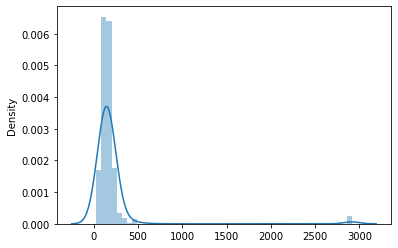

In [18]:
doc_lengths = []

for bio in text:
  
    # get rough token count distribution
    tokens = nltk.word_tokenize(bio[0])

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)
             

In [19]:
torch.cuda.empty_cache()

In [23]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-small")
tokenizer.add_tokens(["<|patient|>", "<|doctor|>"], special_tokens=True)

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/641 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

2

In [32]:
batch_size = 2
tokenizer.pad_token = tokenizer.eos_token

unique_vals = qa_df.id[len(qa_df)-1]

train_split1 = pd.read_pickle("/content/drive/MyDrive/CS685/splits/1.pickle")
train_split2 = pd.read_pickle("/content/drive/MyDrive/CS685/splits/2.pickle")
train_split3 = pd.read_pickle("/content/drive/MyDrive/CS685/splits/3.pickle")
val_split = pd.read_pickle("/content/drive/MyDrive/CS685/splits/4.pickle")
test_split = pd.read_pickle("/content/drive/MyDrive/CS685/splits/5.pickle")

train_split = pd.concat([train_split1, train_split2, train_split3])

print(train_split.columns)
print(train_split.head())

print("length of dataset: " + str(unique_vals))
print('{:>5,} training samples'.format(len(train_split)))
print('{:>5,} validation samples'.format(len(val_split)))
print('{:>5,} test samples'.format(len(test_split)))

train_dataset = GPT2Dataset(train_split, tokenizer, max_length=768)
val_dataset = GPT2Dataset(val_split, tokenizer, max_length=768)
test_dataset = GPT2Dataset(test_split, tokenizer, max_length=768)

Index(['id', 'encoder', 'decoder', 'text'], dtype='object')
     id  ...                                               text
0   963  ...  [<|patient|>What is the suggested medicine for...
1   877  ...  [<|patient|>What causes problem problem in bre...
2   342  ...  [<|patient|>If I'm not sure if I have allergie...
3  1040  ...  [<|patient|>What could itchy small firm white ...
4   881  ...  [<|patient|>Suggest medication for sore throat...

[5 rows x 4 columns]
length of dataset: 571
  855 training samples
  142 validation samples
  144 test samples


In [26]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
)

In [28]:
useCuda = True
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [34]:
class Baseline:
  def __init__(self, tokenizer, patient, doctor):
    self.questionEmbeddingToAnswer = {}
    self.keysToQuestionEmb = {}
    self.tokenizer = tokenizer
    self.tokenizer.pad_token = self.tokenizer.eos_token
    self.embeddings = []
    self.createQuestionEmbeddingToAnswer(patient, doctor)
    self.neighbors = NearestNeighbors(n_neighbors=1, radius=0.4)
    self.neighbors.fit(torch.stack(self.embeddings))

  def getEmbedding(self, sentence):
    input_ids = tokenizer(sentence, max_length=32, truncation=True, padding="max_length", return_tensors='pt').input_ids
    return input_ids.squeeze()

  def createQuestionEmbeddingToAnswer(self, patient, doctor):
    count = 0
    for q, a in zip(patient, doctor):
      # q, a = qa.split("<|endoftext|>")
      embedding = self.getEmbedding(q)
      self.questionEmbeddingToAnswer[count] = (q, a)
      self.embeddings.append(embedding)
      count += 1

  def findClosestKPairs(self, questionEmb):
    try: 
      id = self.neighbors.kneighbors(questionEmb, 1, return_distance=False)
    except Exception as err:
      print(err)

  def retrieveClosestAnswerGivenQuestion(self, input):
    # Given a question, return the answer associated to the closest question embedding
    kPairs = self.findClosestKPairs(input)
    
    

In [35]:
b = Baseline(tokenizer, train_split["encoder"], train_split["decoder"])

In [38]:
import csv
# open the file in the write mode
with open('baseline5.csv', 'w') as f:
    # create the csv writer
    writer = csv.writer(f)
    header = ["input", "prediction", "ground"]
    # write a row to the csv file
    writer.writerow(header)
    for patient, doctor in zip(test_split["encoder"][0:30], test_split["decoder"][0:30]):
      tokenized_inputs = tokenizer(patient,  max_length=32, truncation=True, padding="max_length", return_tensors='pt').input_ids
      pred_train_question_id = b.neighbors.kneighbors(tokenized_inputs, 1, return_distance=False)[0][0]
      pred_answer = b.questionEmbeddingToAnswer[pred_train_question_id][1]
      row = patient + pred_answer + doctor
      writer.writerow(row)